In [1]:
# Install the GUS framework.
import os
import sys

!{sys.executable} -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple gus==0.1.7

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def percentage_change(current_value, initial_value):
    """The function to copmpute percentage change with respect to a given base value."""
    if initial_value == 0:
        return 0

    return ((current_value - initial_value) / initial_value) * 100


def compute_under_canopy_area_m2(crown_diameter):
    return pow((crown_diameter / 2), 2) * np.pi


def compute_leaf_area_index(
    dbh,
    tree_height,
    crown_depth,
    crown_diameter,
    crown_missing=0,
    shade_factor=0.85,
):
    """The function given allometrics of a tree computes its leaf, bark and plant area indices.

    Args:
        dbh: (:obj:`float`): the diameter in cm of the trunk usually measured at 1.3m from the ground.
        tree_height: (:obj:`float`): The tree height in meters.
        crown_debth: (:obj:`float`): The vertical length of tree crown in meters.
        crown_diameter: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.
        crown_missing: (:obj:`float`): The percentage loss of the crown.
        shade_factor: (:obj:`float`): The percentage of sky covered by foliage and branches.

        Shade factor, is the percentage of sky covered by foliage and branches within the perimeter of individual tree crowns,
        can vary by species from about 60% to 95% when trees are in-leaf (McPherson, 1984). The value below is set according to
        Glasgow mean and needs to be updated per city or per tree.

    Returns:
        (:obj:`float`): It eturns the LAI.
    Note:
        The beta multipliers and the main equation is based on Nowak (1996).

    TODO:
        Parametrize beta multipliers.
    """
    loss = crown_missing
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    sf = shade_factor
    beta_0 = -4.3309
    beta_1 = 0.2942
    beta_2 = 0.7312
    beta_3 = 5.7217
    beta_4 = 0.0148

    # Outer surface area estimate below is based on Gacka-Grzesikiewicz (1980).
    under_canopy = compute_under_canopy_area_m2(cw)
    crown_surface = np.pi * cw * (cd + cw) / 2
    leaf_area = (1 - loss) * np.exp(
        beta_0 + beta_1 * th + beta_2 * cw + beta_3 * sf - beta_4 * crown_surface
    )
    leaf_area_index = leaf_area / under_canopy  # m^2/m^2
    return leaf_area_index  # An intuitive way to think about LAI is as the one-sided green leaf area per unit ground surface area. !!


def compute_gross_canopy_index(tree_height, crown_depth, crown_diameter):
    """The function given allometrics of a tree computes an index to account shading effect immediately underneath its canopy.

    Args:
        tree_height: (:obj:`float`): The tree height in meters.
        crown_height: (:obj:`float`): The vertical length of tree crown in meters.
        crown_width: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.

    Returns:
        (:obj:`float`): returns the GCI index
    Note:
        The index is based on (Zhang et.al., 2020). It accounts for the overall immediate shading effect of a tree.
        It accounts both crown diameter (tw) and the crown base height (th - ch), the distance from the ground to the start of
        the canopy.
    """
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    crown_base_height = th - cd
    if crown_base_height < 0.1:
        crown_base_height = 0.1
    GCI = cw / crown_base_height
    return GCI  # GCI is just a ratio of crown diameter to crown base height. It is a measure of the overall immediate shading effect of a tree.


def compute_crown_volume_index(leaf_area_index, crown_canopy_index):
    """The function given computes a composite index taking into account both leaf density and canopy shape.

    Args:
        leaf_area_indext: (:obj:`float`): The index on the leaf density per the area under the canopy.
        crown_canopy_index: (:obj:`float`): The index that accounts for the geomtric shape of the canopy relevant to shading.

    Returns:
        (:obj:`float`): returns the CVI index
    Note:
        The index is adopted from (Zhang et.al., 2020).
    """
    # CVI is a composite index taking into account both leaf density and canopy shape.
    return leaf_area_index * crown_canopy_index


dT_max = 0.67
m1 = 0.1
m2 = 0.75
m4 = 0.75
m5 = 0.2
T0 = 10
T1 = 18
T2 = 26
T3 = 35
T4 = 45
T5 = 50
avg_conifer_cooling_factor = 0.66


def cooling_multiplier(T):
    if T < T0:
        return 0
    if T < T1:
        return m1 * dT_max
    if T < T2:
        return m2 * dT_max
    if T < T3:
        return dT_max
    if T < T4:
        return m4 * dT_max
    if T < T5:
        return m5 * dT_max
    return 0


# Comparing this index of the canopy, and how it changes across a timespan from A to B
# We can estimate the further cooling potential of that tree canopy in B relative to A (in degrees C)
def compute_cooling(canopy_change_cvi, T=30, species=None):
    # The CVI is a composite index taking into account both leaf density and canopy shape. The higher the CVI the greater the cooling effect.
    if species == "conifer":
        species_factor = 0.6
    elif species == "decidu":
        species_factor = 0.9
    else:
        species_factor = 1
    return species_factor * np.sqrt(canopy_change_cvi / 10) * cooling_multiplier(T)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
# quite a small but detail figure 50% size
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_palette("Set2")

<Figure size 1000x500 with 0 Axes>

# Park/Private vs Street Trees
## An investigation in Songpa

In [39]:
songpa_uncleaned = pd.read_csv("songpa_seoul/data/Park_PrivateLande_Trees_Songpa_2.csv")
junk = [
    "GU_NM",
    "WDPT_NM",
    "HNR_NAM",
    "MTC_AT",
    "MASTERNO",
    "SLAVENO",
    "NEADRES_NM",
    "GU_NO",
    "DONG_NM",
    "SN",
    "MGE_MAN",
    "MGE_ORG",
    "CREAT_DE",
    "CMFE_LU_ST",
    "REG_YMD",
    "REGIST_NO",
    "PSS_MAN",
    "SPY_STTN",
    "DME_STTN",
    "MGE_LVL",
    "ITM_TYPE",
    "ITM_LVL",
    "VTN_ERY",
    "PO_FE_NM",
    "GRID_ID_200",
    "GRID_ID_100",
]
songpa_uncleaned = songpa_uncleaned.drop(columns=junk, axis=1)
# songpa_uncleaned.head(25)

In [40]:
songpa_street = pd.read_csv("songpa_seoul/data/Songpa_Street.csv")
songpa_park = pd.read_csv("songpa_seoul/data/Songpa_Park.csv")
# songpa_street[["id", "dbh", "height", "species", "condition", "lat", "lng"]].head(25)

In [41]:
# print(songpa_street.columns)
# print(songpa_park.columns)

# print("average height in park data: ", songpa_park['height'].mean())
# print("average height in street data: ", songpa_street['height'].mean())

# print("average dbh in park data: ", songpa_park['dbh'].mean())
# print("average dbh in street data: ", songpa_street['dbh'].mean())

# print("average crown width in park data: ", songpa_park['CrownW'].mean())
# print("average crown width in street data: ", songpa_street['CrownW'].mean())

# species = songpa_street['species'].unique()
# print("number of trees in park data: ", len(songpa_park))
# print("number of each species in park data: ")
# print(songpa_park['species'].value_counts())
# print("number of trees in street data: ", len(songpa_street))
# print("number of each species in street data: ")
# print(songpa_street['species'].value_counts())

## What do we have now?

Our DataFrame now contains 25 years of data concerning more than 30,000 trees in the Songpa district of Seoul.
Each has a unique AgentID, and by taking a cross-section of the data based on that AgentID, we can examine the evolution of various characteristics of the tree agents through the years of the simulation.

At that point, we can feed these arrays into the functions for leaf area index (LAI), gross canopy index (GCI), and crown volume index (CVI). These indices can then be used to track the evolution of a given agent 

We have multi-dimensional data, by year, and also by tree_agent. We could split the data first by year, comparing 0, and the year_in_question (whichever we decide to examine), then indexing on the grid_id, 

In [48]:
if os.path.exists("songpa_agents_25yrs.csv"):
    all_songpa_agents_25yrs = pd.read_csv("songpa_agents_25yrs.csv")
else:
    all_songpa_agents_25yrs = pd.read_csv(
        "https://treesai-gus-public.s3.eu-west-3.amazonaws.com/inputs/songpa_yearly.csv"
    )
    all_songpa_agents_25yrs.to_csv("songpa_yearly.csv", index=False)

all_songpa_agents_25yrs.rename(columns={"Step": "year"}, inplace=True)
all_songpa_agents_25yrs.set_index("AgentID", inplace=True)

# # of AgentID's per year
agents_per_year = {}
# rewrite as map
for i in range(1, all_songpa_agents_25yrs["year"].max() + 1):
    agents = len(all_songpa_agents_25yrs[all_songpa_agents_25yrs["year"] == i])
    agents_per_year[i] = agents

agents_per_year = pd.DataFrame.from_dict(
    agents_per_year, orient="index", columns=["agents"]
)

all_songpa_agents_25yrs.tail(10)

,year,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates,100_GRID_ID
AgentID,,,,,,,,,,,,,,,,,,,
43593,25,decidu,1.139367,4.133814,2.303374,2.023323,0,0.56,excellent,0.006748,0.317563,0.0,0.158782,0.0,0.0,0.0,0.0,"(6466, 5298)",124568
43594,25,decidu,1.049663,4.133814,2.303374,2.023323,0,0.56,excellent,0.007668,0.264053,0.0,0.132027,0.0,0.0,0.0,0.0,"(2376, 4159)",109774
43595,25,decidu,1.049328,4.133814,2.303374,2.023323,0,0.56,excellent,0.008616,0.263864,0.0,0.131932,0.0,0.0,0.0,0.0,"(352, 4644)",102203
43596,25,decidu,1.113002,4.133814,2.303374,2.023323,0,0.56,excellent,0.000842,0.301267,0.0,0.150633,0.0,0.0,0.0,0.0,"(4497, 4116)",117670
43597,25,decidu,1.748104,4.133814,2.303374,2.023323,0,0.56,excellent,0.009870,0.832060,0.0,0.416030,0.0,0.0,0.0,0.0,"(4373, 2342)",117357
43598,25,decidu,1.598991,4.133814,2.303374,2.023323,0,0.56,excellent,0.007720,0.680806,0.0,0.340403,0.0,0.0,0.0,0.0,"(4906, 2443)",119330
43599,25,decidu,1.161639,4.133814,2.303374,2.023323,0,0.56,excellent,0.003169,0.331703,0.0,0.165852,0.0,0.0,0.0,0.0,"(4817, 2444)",118673
43600,25,decidu,1.960317,4.133814,2.303374,2.023323,0,0.56,excellent,0.000083,1.076772,0.0,0.538386,0.0,0.0,0.0,0.0,"(4029, 2727)",116038
43601,25,decidu,1.878110,4.133814,2.303374,2.023323,0,0.56,excellent,0.000614,0.977817,0.0,0.488908,0.0,0.0,0.0,0.0,"(4983, 1886)",119664


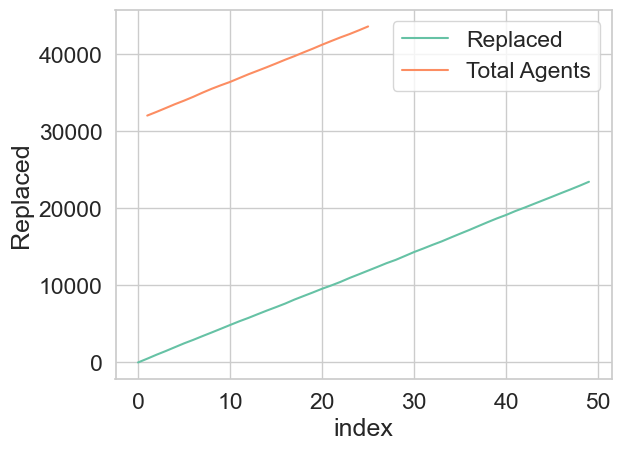

In [46]:
songpa_impacts = pd.read_csv("songpa_impacts.csv")
# drop Unnamed: 0
songpa_impacts = songpa_impacts.drop(columns=["Unnamed: 0"], axis=1)
songpa_impacts.to_json("songpa_impacts.json")
print(songpa_impacts.head())

# add a column, total agents per year
songpa_impacts["Total Agents"] = agents_per_year["agents"]
# show both replaced and total trees per year
sns.lineplot(
    data=songpa_impacts.reset_index(), x="index", y="Replaced", label="Replaced"
)
sns.lineplot(
    data=songpa_impacts.reset_index(), x="index", y="Total Agents", label="Total Agents"
)
plt.show()

In [ ]:
all_grid_ids = all_songpa_agents_25yrs["GRID_ID_100"].unique()
df_year_1 = all_songpa_agents_25yrs[all_songpa_agents_25yrs["year"] == 1]
df_year_1.set_index("GRID_ID_100", inplace=True)
print(len(df_year_1))

##TODO: Make what ever comes next a function, and loop through each of the 10 years
N = 10  # Year in question 

df_year_N = all_songpa_agents_25yrs[all_songpa_agents_25yrs["year"] == N]
df_year_N.set_index("GRID_ID_100", inplace=True)
print(len(df_year_N))


print(df_year_1.tail())

# Average tree height in year 1
avg_1 = df_year_1["height"].mean()

# Average tree height in year N
avg_N = df_year_N["height"].mean()

print(avg_1, avg_N)
# find the average increase in crownH and crownW between df_year_1 and df_year_N
# unique_ids = songpa_df["Unnamed: 0"].unique()
# for id in unique_ids:
#     pass

print(df_year_N.tail())

13.67853601441381 15.054009336199492


## Cooling Effect
Now we analyse the cooling effect of each grid cell, by analysing the tree canopies present in that cell

In [5]:
# CONSTANTS

# TODO: Make a lookup for the temperature per grid_id
grid_temperature = 26  # C
CELL_AREA = 100 * 100  # m^2

def calculate_nth_year_CVI_and_percentage_canopy_cover(grid_df_N):
    nth_CVIs = grid_df_N.apply(
        lambda row: compute_crown_volume_index(
            compute_leaf_area_index(
                row["dbh"], row["height"], row["crownH"], row["crownW"]
            ),
            compute_gross_canopy_index(row["height"], row["crownH"], row["crownW"]),
        ),
        axis=1,
    )

    # Same for the coverage in year N
    percentage_canopy_cover_N = (
        grid_df_N.apply(
            lambda row: compute_under_canopy_area_m2(row["crownW"]), axis=1
        ).sum()
        / CELL_AREA # percentage of the grid cell covered by the canopy
    ) * 100
    
    return nth_CVIs, percentage_canopy_cover_N

def compare_cooling_effect_between_years(df: pd.DataFrame, N: int, scope: str):
    all_grid_ids = df["GRID_ID_100"].unique()
    df_year_1 = df[df["Step"] == 1]
    df_year_1.set_index("GRID_ID_100", inplace=True)
    df_year_N = df[df["Step"] == N]
    df_year_N.set_index("GRID_ID_100", inplace=True)
    
    # for statistics later
    trees_per_grid_1 = []
    trees_per_grid_N = []

    empty_grid_cells = []
    all_dTs_for_avg = []

    grid_cell_dTs = {}
    grid_cell_dCoverages = {}

    # Over all the grid ids that are present in the dataframe
    for grid in all_grid_ids:
        # Comparing this grid cell in year 1 and year N
        grid_df_1 = df_year_1.xs(grid)
        grid_df_N = df_year_N.xs(grid)
        trees_per_grid_1.append(len(grid_df_1))
        trees_per_grid_N.append(len(grid_df_N))
        
        if grid_df_1.empty or grid_df_N.empty:
            print("Empty grid: {}".format(grid))
            empty_grid_cells.append(grid)
            continue
        # And use these to compute the change in LAI, GCI, CVI

        # there will be some elements in the year N data, which weren't present in the original, so we'll need to find out which ones they are
        # we can match based on the coordinates (x, y)
        # first, which elements are in grid_df_N but not in grid_df_1?

        # There's surely a better way of handling this. How do the leaf area indices combine over a 100x100m grid?
        try:
            # For each of the grids, we collect the trees in the cell, as a cross section
            # From here, we can compute the average LAI, GCI, CVI, per row in the grid
            # We can then compute the average LAI, GCI, CVI, per grid

            initial_CVIs, percentage_canopy_cover_1 = calculate_nth_year_CVI_and_percentage_canopy_cover(grid_df_1)
            nth_CVIs, percentage_canopy_cover_N = calculate_nth_year_CVI_and_percentage_canopy_cover(grid_df_N)

            # We collect the maps, so we can visualise later in QGIS
            grid_cell_dCoverages[grid] = percentage_canopy_cover_N - percentage_canopy_cover_1

            # Subtract the two to get the change in CVI
            # WARNING: This is a very crude way of doing it, as it doesn't take into account the change in the number of trees (thanks, GPT)
            # A human warning: this only works if the trees are in the same order in both dataframes
            delta_CVI = nth_CVIs - initial_CVIs
            # print("Delta CVI for grid {} is {}".format(grid, delta_CVI))
            avg_dCVI = delta_CVI.mean()

            species = grid_df_1["species"].unique()
            if avg_dCVI > 0:
                dT = compute_cooling(avg_dCVI, T=grid_temperature, species=species[0])
                # print("Cooling for cell {} is {}".format(grid, dT))
                grid_cell_dTs[grid] = dT
                all_dTs_for_avg.append(dT)
            else:
                grid_cell_dTs[grid] = 0.0
        except:
            # print("Error with grid {}".format(grid))
            continue
        
    # Some statistics
    print("{}_{} statistics:".format(scope, N))
    print("Average trees per grid in year 1: {}".format(np.mean(trees_per_grid_1)))
    print("Average trees per grid in year N: {}".format(np.mean(trees_per_grid_N)))
    print("Most trees per grid in year 1: {}".format(np.max(trees_per_grid_1)))
    print("Most trees per grid in year N: {}".format(np.max(trees_per_grid_N)))
    print("Least trees per grid in year 1: {}".format(np.min(trees_per_grid_1)))
    print("Least trees per grid in year N: {}".format(np.min(trees_per_grid_N)))

    average_dT = np.mean(all_dTs_for_avg)
    # replace all 0.0s with the average dT
    grid_cell_dTs = {k: average_dT if v == 0.0 else v for k, v in grid_cell_dTs.items()}

    grid_cell_dTs = pd.DataFrame.from_dict(grid_cell_dTs, orient="index")
    grid_cell_dTs.index.name = 'GRID_ID_100'
    grid_cell_dTs.rename(columns={0: 'dT'}, inplace=True)
    print(grid_cell_dTs.tail())

    print("Average dT: {}".format(average_dT))
    
    # Percentage increase in canopy coverage per grid cell
    canopy_coverage_increase = pd.DataFrame.from_dict(grid_cell_dCoverages, orient="index")
    print(canopy_coverage_increase.head())
    return grid_cell_dTs, canopy_coverage_increase


In [6]:
# Next, the job will be to analyse the cooling effect of each of the maintenance scopes, for each of the 10 years, from 1 to 10

root_dir = os.path.join(os.getcwd(), "songpa_seoul", "VAIV_october_18")
results_dir = os.path.join(root_dir, "results")
scenarios = ["Songpa_Park_and_Street.csv", "combined_all_songpa.csv"]

def run_cooling_scenario(scenario, scope, n, out_dir):
    file_name = "songpa_agents_{}_{}.csv".format(scope, scenario)
    
    df = pd.read_csv(os.path.join(root_dir, file_name))
    grid_cell_dTs, canopy_cover_increase = compare_cooling_effect_between_years(df, n, scope)
    
    grid_dTs_filename = os.path.join(out_dir, "{}_grid_dTs_{}.csv".format(n, scope))
    
    # should save to something of the form:
    #   combined_all_songpa.csv/low/3_grid_dTs_low.csv
    # or
    #   Songpa_Park_and_Street.csv/high/10_grid_dTs_high.csv
    
    grid_cell_dTs.to_csv(grid_dTs_filename)

# For each of the original and the new scenario
for scenario in scenarios:
    # create `results_dir`/`scenario` if it doesn't exist
    scenario_dir = os.path.join(results_dir, scenario)
    if not os.path.exists(scenario_dir):
        os.makedirs(scenario_dir)
        
    # Across the 3 different maintenance scopes
    for maintenance_scope in [0,1,2]:
        if maintenance_scope == 0:
            scope = "low"
        elif maintenance_scope == 1:
            scope = "med"
        else:
            scope = "high"
            
        # create `results_dir`/`scenario`/`scope` if it doesn't exist
        scope_dir = os.path.join(scenario_dir, scope)
        if not os.path.exists(scope_dir):
            os.makedirs(scope_dir)
        
        # For each of the 10 years
        for n in range(1, 11):    
            run_cooling_scenario(scenario, scope, n, scope_dir)